In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.graphics import tsaplots

from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit

## Helper functions

In [2]:
def time_plotter(data, title=None, ax=None):
    fig = data.plot(figsize=(16, 5), title=title, ax=ax)
    fig.minorticks_on()
    fig.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.6)
    fig.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)

## Data prep

In [3]:
dailys = []
for file in tqdm(os.listdir("assets/")):
    data = pd.read_csv(f"assets/{file}")
    data["sym"] = file[:-4]
    data["time"] = pd.to_datetime(data["time"], unit="ms")
    data = data.set_index("time")
    
    daily_close = data[["sym", "close"]].resample("1D").last()
    dailys.append(daily_close)

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [00:54<00:00,  7.79it/s]


In [4]:
daily = pd.concat(dailys)

In [5]:
first_dates = (daily.reset_index().groupby("sym").first()
               .reset_index().sort_values("time")
              )

In [6]:
keep_syms = first_dates[first_dates["time"] <= "2018-01-01"]["sym"].unique()
print(len(keep_syms))

49


In [7]:
keep_daily = daily[daily["sym"].isin(keep_syms)].loc["2018-01-01":"2021-12-31"]
keep_daily = keep_daily.set_index("sym", append=True).unstack("sym")["close"]

In [8]:
keep_daily

sym,avtusd,btceur,btcusd,btgbtc,btgusd,datbtc,datusd,dshbtc,dshusd,edobtc,...,sanbtc,saneth,sanusd,xmrbtc,xmrusd,xrpbtc,xrpusd,yywusd,zecbtc,zecusd
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,4.3501,11133.000000,13376.0,0.017510,233.910,0.000016,0.21599,0.075880,1018.40,0.000315,...,0.000407,0.007218,5.45280,0.025201,337.35,0.000152,2.03950,0.29672,0.038430,513.51
2018-01-02,4.8223,12190.000000,14722.0,0.017272,253.450,0.000016,0.23990,0.078710,1162.90,0.000296,...,0.000426,0.007499,6.32810,0.024751,364.23,0.000149,2.19300,0.32414,0.037153,547.88
2018-01-03,4.9444,12611.930380,15150.0,0.016210,245.630,0.000021,0.31060,0.074679,1131.40,0.000318,...,0.000437,0.007047,6.64400,0.025456,386.00,0.000180,2.73170,0.40344,0.037096,559.70
2018-01-04,4.5806,12553.152741,15159.0,0.015500,234.330,0.000020,0.30030,0.073563,1118.00,0.000340,...,0.000447,0.007583,7.15700,0.024498,372.50,0.000181,2.73670,0.40173,0.035959,545.11
2018-01-05,4.7399,14061.196800,16911.0,0.013692,232.080,0.000016,0.27160,0.063586,1079.80,0.000300,...,0.000433,0.007658,7.39220,0.021088,357.62,0.000147,2.49610,0.50470,0.031951,541.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,NaN,44734.077070,50690.0,0.000893,45.325,0.000003,0.13210,0.002976,150.80,0.000020,...,0.000007,0.000097,0.34521,0.004355,220.75,0.000018,0.92690,NaN,0.003346,169.65
2021-12-28,NaN,42022.000000,47556.0,0.000874,41.807,0.000003,0.12171,0.002841,134.72,0.000020,...,0.000007,0.000095,0.33000,0.004389,209.19,0.000018,0.85163,NaN,0.003144,149.54
2021-12-29,NaN,40916.000000,46465.0,0.000870,40.427,0.000002,0.12023,0.002867,133.42,0.000020,...,0.000007,0.000085,0.33031,0.004624,214.61,0.000018,0.81760,NaN,0.003153,146.66


## Splitting the data into train and test data sets

In [9]:
train_test_split_index = int(len(keep_daily) / 2)
train_test_split_index 

730

In [10]:
train_data = keep_daily[:train_test_split_index]
test_data = keep_daily[train_test_split_index:]

In [11]:
train_data.to_pickle("train_data.pkl")
test_data.to_pickle("test_data.pkl")

## Finding mean reverting pairs

In [12]:
rets = train_data.pct_change()

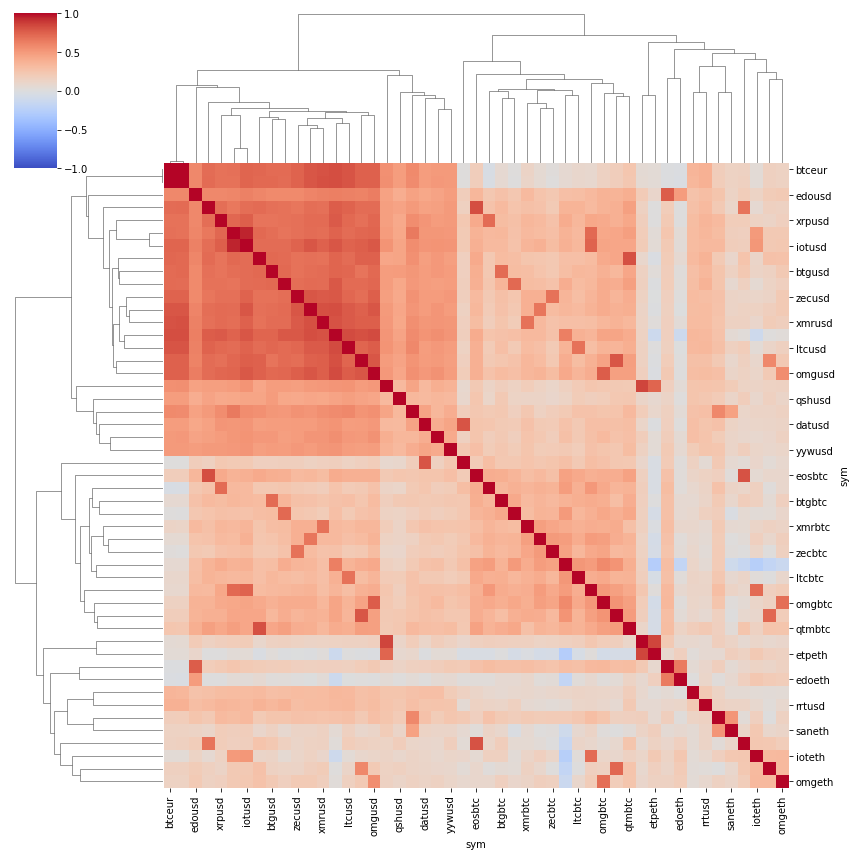

In [13]:
grid = sns.clustermap(rets.corr(), cmap="coolwarm", figsize=(12, 12), vmin=-1, vmax=1);

In [14]:
reordered_syms = [keep_daily.columns[i] for i in grid.dendrogram_row.reordered_ind]

In [15]:
print(reordered_syms)

['btceur', 'btcusd', 'edousd', 'eosusd', 'xrpusd', 'ioteur', 'iotusd', 'qtmusd', 'btgusd', 'etcusd', 'zecusd', 'dshusd', 'xmrusd', 'ethusd', 'ltcusd', 'neousd', 'omgusd', 'etpusd', 'qshusd', 'sanusd', 'datusd', 'gntusd', 'yywusd', 'datbtc', 'eosbtc', 'xrpbtc', 'btgbtc', 'etcbtc', 'xmrbtc', 'dshbtc', 'zecbtc', 'ethbtc', 'ltcbtc', 'iotbtc', 'omgbtc', 'neobtc', 'qtmbtc', 'etpbtc', 'etpeth', 'edobtc', 'edoeth', 'avtusd', 'rrtusd', 'sanbtc', 'saneth', 'eoseth', 'ioteth', 'neoeth', 'omgeth']


In [16]:
cluster1_syms = ['btceur', 'btcusd', 'edousd', 'eosusd', 'xrpusd', 'ioteur', 'iotusd', 'qtmusd', 'btgusd', 'etcusd', 'zecusd', 'dshusd', 'xmrusd', 'ethusd', 'ltcusd', 'neousd', 'omgusd']

In [17]:
print(len(cluster1_syms))

17


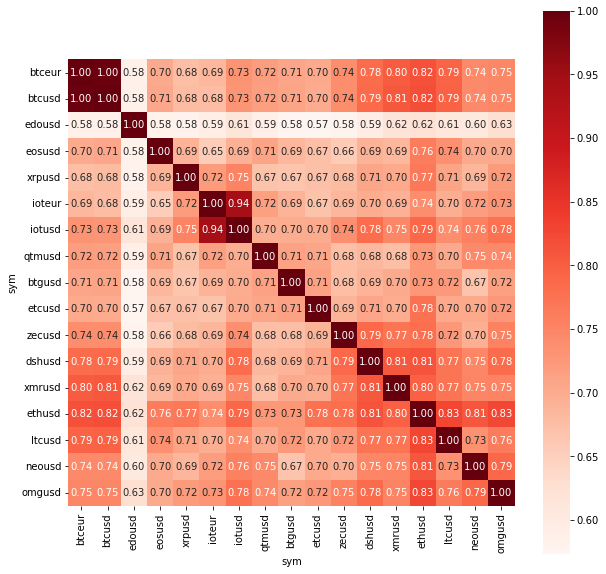

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(rets[cluster1_syms].corr(), square=True, cmap="Reds", annot=True, fmt=".2f", ax=ax);

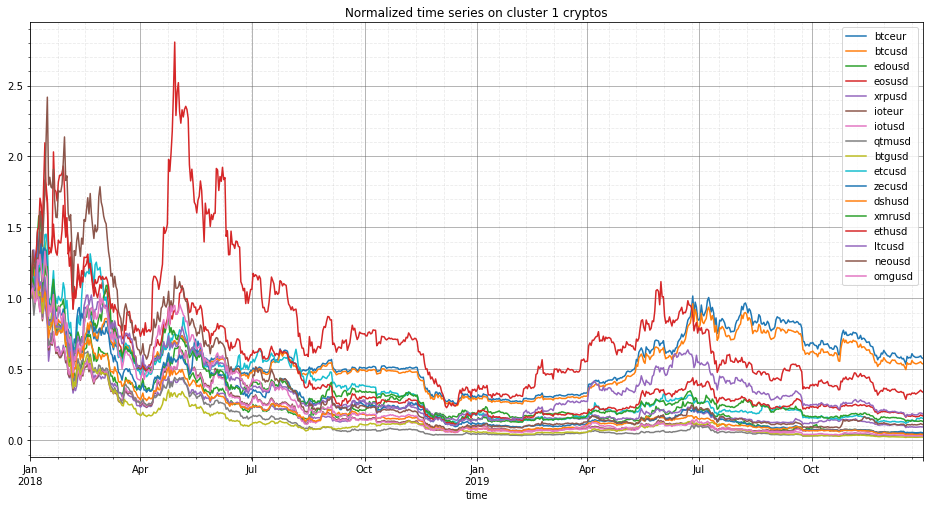

In [19]:
ax = (rets[cluster1_syms].fillna(0) + 1).cumprod().plot(figsize=(16, 8), title="Normalized time series on cluster 1 cryptos")
ax.minorticks_on()
ax.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.6)
ax.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
ax.legend(loc="upper right");

In [20]:
coint_results = []
for sym1, sym2 in tqdm(list(combinations(cluster1_syms, 2))):
    pair_daily = keep_daily[[sym1, sym2]].dropna()
    coint_result = coint(pair_daily[sym1], pair_daily[sym2])
    coint_results.append([sym1, sym2, coint_result[1]])

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.35it/s]


In [21]:
coints = pd.DataFrame(coint_results, columns=["sym1", "sym2", "pvalue"]).sort_values("pvalue")

In [22]:
mean_reverting_pairs = round(coints[coints["pvalue"] <= 0.05], 3)
print(f"Total no. of pairs: {len(mean_reverting_pairs)}")
print(mean_reverting_pairs.head(), "\n\n", mean_reverting_pairs.tail())

Total no. of pairs: 57
       sym1    sym2  pvalue
104  btgusd  ethusd     0.0
103  btgusd  xmrusd     0.0
100  btgusd  etcusd     0.0
105  btgusd  ltcusd     0.0
96   qtmusd  ethusd     0.0 

       sym1    sym2  pvalue
58  xrpusd  ioteur   0.035
57  eosusd  omgusd   0.036
50  eosusd  etcusd   0.042
59  xrpusd  iotusd   0.043
48  eosusd  qtmusd   0.044


In [23]:
mean_reverting_pairs.to_pickle("mean_reverting_pairs.pkl")

## Serial correlation

In [24]:
rets_nona = rets.dropna()

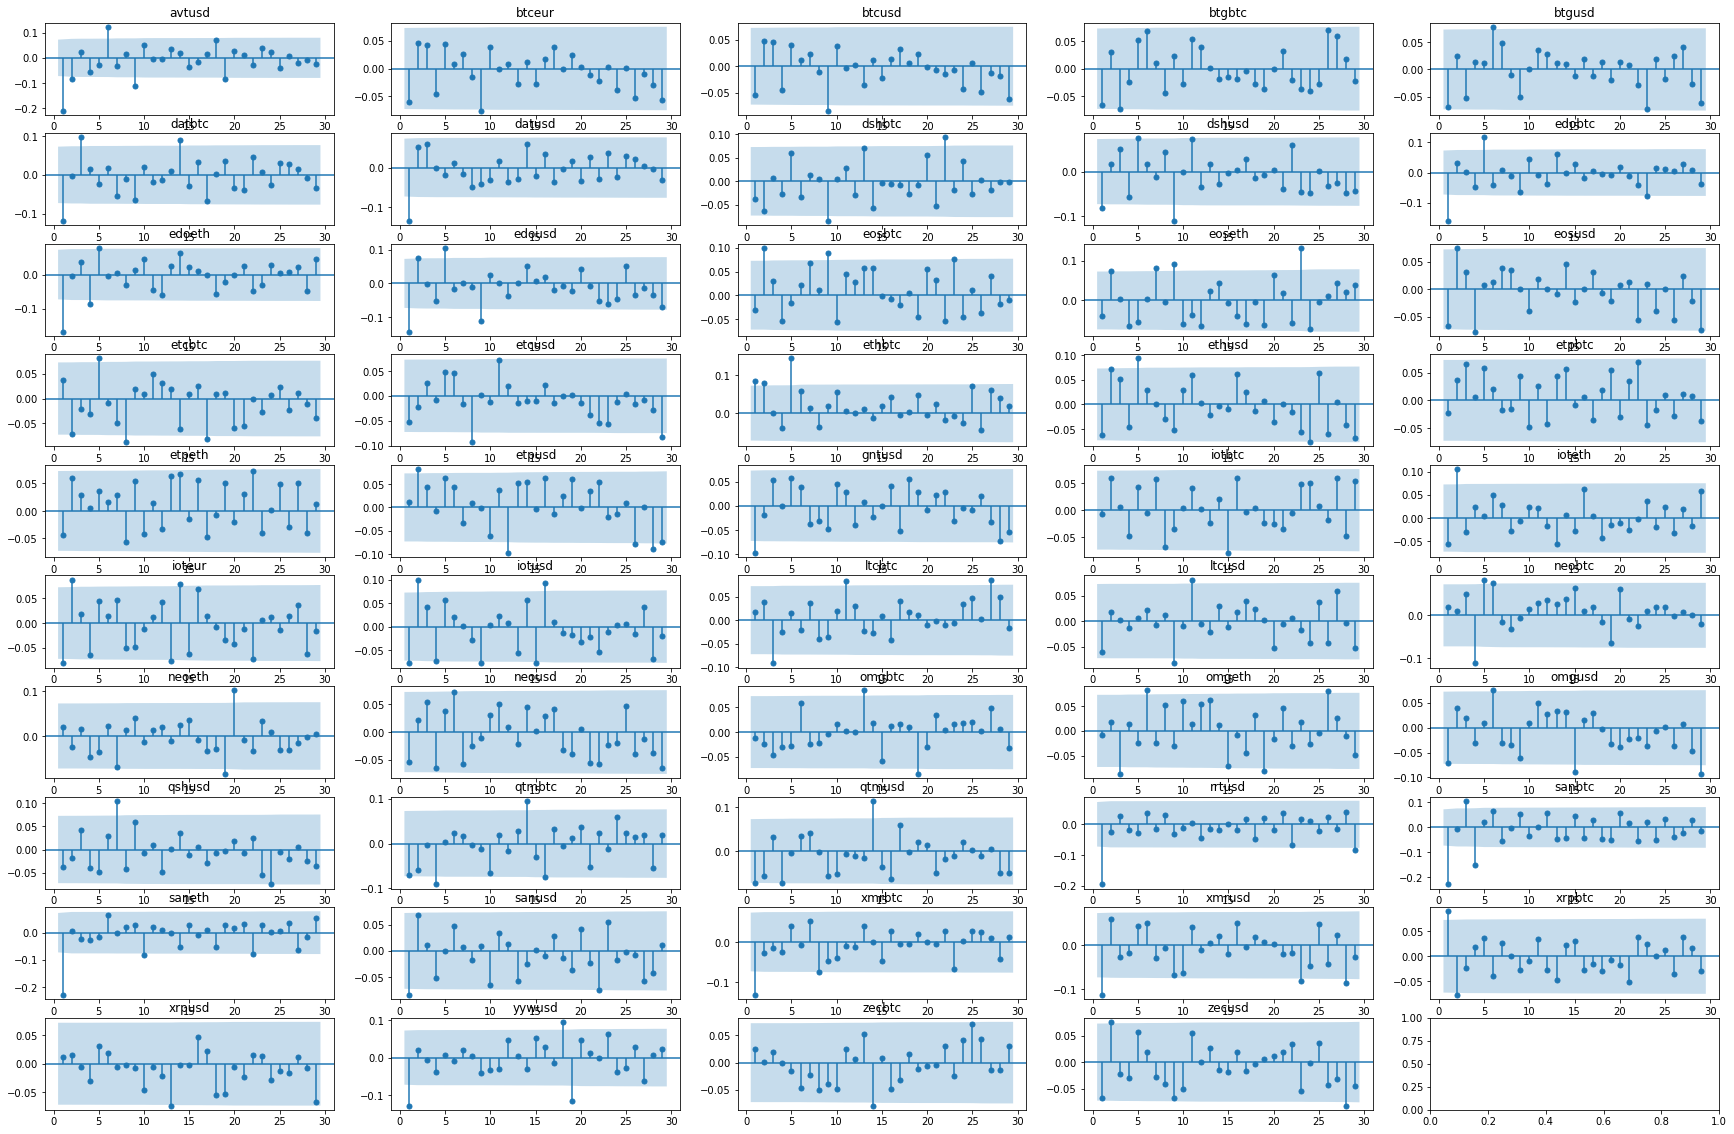

In [25]:
fig, ax = plt.subplots(ncols=5, nrows=10, figsize=(30, 20))
for i, sym in enumerate(rets.columns):
    tsaplots.plot_acf(rets_nona[sym], ax=ax[i//5, i%5], title=sym, zero=False);

In [26]:
momentum_syms = ["avtusd", "rrtusd", "sanbtc", "saneth"]

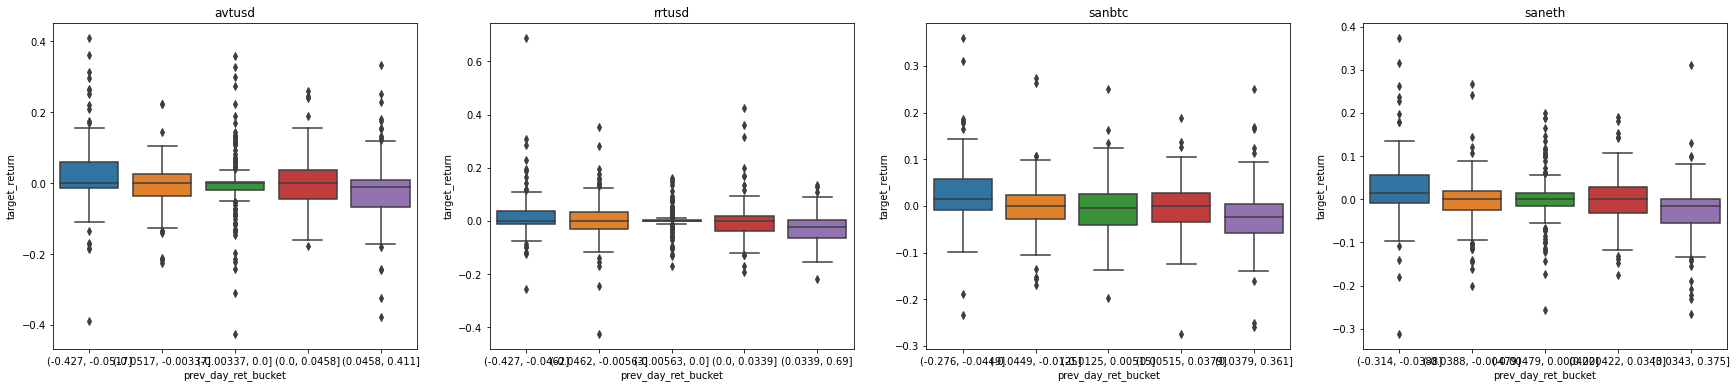

In [27]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(30, 6))
for i, sym in enumerate(momentum_syms):
    temp = rets_nona[[sym]].copy(deep=True)
    temp["prev_day_ret_bucket"] = pd.qcut(temp[sym], 5)
    temp["target_return"] = rets_nona[sym].shift(-1)
    sns.boxplot(data=temp, x="prev_day_ret_bucket", y="target_return", ax=ax[i]).set_title(sym);

## Weekly momentum

In [28]:
factors = train_data.resample("1W").last().pct_change().stack("sym")
factors.name = "factor"
factors

time        sym   
2018-01-14  avtusd   -0.287295
            btceur   -0.173809
            btcusd   -0.163879
            btgbtc    0.338421
            btgusd    0.114940
                        ...   
2020-01-05  xrpbtc    0.007898
            xrpusd   -0.020470
            yywusd   -0.004951
            zecbtc   -0.030285
            zecusd   -0.057115
Name: factor, Length: 5096, dtype: float64

In [29]:
forward_returns = train_data.resample("1W").last().pct_change().shift(-1).stack("sym")
forward_returns.name = "fwdret"
forward_returns

time        sym   
2018-01-07  avtusd   -0.287295
            btceur   -0.173809
            btcusd   -0.163879
            btgbtc    0.338421
            btgusd    0.114940
                        ...   
2019-12-29  xrpbtc    0.007898
            xrpusd   -0.020470
            yywusd   -0.004951
            zecbtc   -0.030285
            zecusd   -0.057115
Name: fwdret, Length: 5096, dtype: float64

In [30]:
factors_returns = pd.merge(factors,forward_returns, left_index=True, right_index=True)
factors_returns["factor_bucket"] = pd.qcut(factors_returns["factor"], 5)

In [31]:
factors_returns.head()

factor    fwdret     factor_bucket
time       sym                                         
2018-01-14 avtusd -0.287295 -0.325702  (-0.675, -0.104]
           btceur -0.173809 -0.156243  (-0.675, -0.104]
           btcusd -0.163879 -0.150760  (-0.675, -0.104]
           btgbtc  0.338421 -0.163564   (0.0645, 1.231]
           btgusd  0.114940 -0.289738   (0.0645, 1.231]

In [32]:
factors_returns[["factor", "fwdret"]].corr()

,factor,fwdret
factor,1.000000,-0.007034
fwdret,-0.007034,1.000000


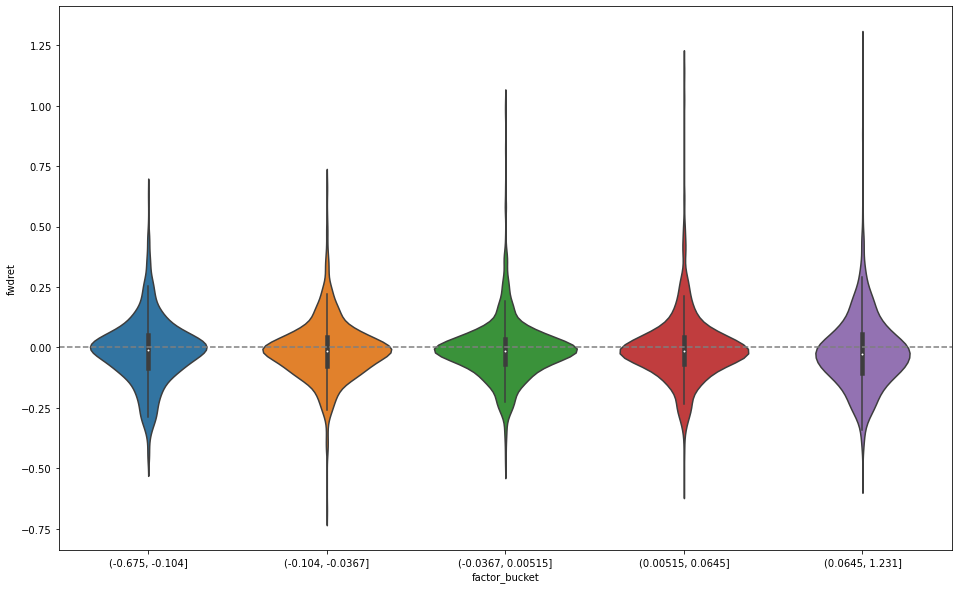

In [33]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.violinplot(data=factors_returns, x="factor_bucket", y="fwdret", ax=ax)
ax.axhline(y=0, color="tab:grey", linestyle="--");

In [34]:
factors_returns.groupby("factor_bucket").describe()["fwdret"].round(4)

,count,mean,std,min,25%,50%,75%,max
factor_bucket,,,,,,,,
"(-0.675, -0.104]",1010.0,-0.0148,0.1354,-0.4635,-0.0865,-0.0086,0.0497,0.6305
"(-0.104, -0.0367]",1009.0,-0.0114,0.1233,-0.6737,-0.0786,-0.0141,0.0419,0.6767
"(-0.0367, 0.00515]",1009.0,-0.0123,0.1280,-0.4767,-0.0702,-0.0138,0.0355,1.0034
"(0.00515, 0.0645]",1009.0,-0.0043,0.1455,-0.5505,-0.0681,-0.0157,0.0442,1.1567
"(0.0645, 1.231]",1010.0,-0.0183,0.1560,-0.5234,-0.1065,-0.0282,0.0539,1.2311
